<a href="https://colab.research.google.com/github/yoandym/colab/blob/main/macd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install mplfinance

In [3]:
# Download data
from datetime import datetime
import yfinance as yf

start_date = datetime(2021, 5, 5)
end_date = datetime(2021, 5, 6)
data = yf.download(tickers='EURUSD=X', start=start_date, end=end_date, interval="1m")

data.head()


     |████████████████████████████████| 6.3MB 10.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=4b6d30c642ff1176a26a61a2f46753aaea70042576a5ddd2a132a76f2a01ebdd
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 71kB 6.9MB/s 
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-05-05 01:00:00+01:00,1.202212,1.202212,1.202212,1.202212,1.202212,0
2021-05-05 01:01:00+01:00,1.201779,1.201779,1.201779,1.201779,1.201779,0
2021-05-05 01:02:00+01:00,1.201923,1.201923,1.201923,1.201923,1.201923,0
2021-05-05 01:03:00+01:00,1.202068,1.202068,1.202068,1.202068,1.202068,0
2021-05-05 01:04:00+01:00,1.202068,1.202068,1.202068,1.202068,1.202068,0


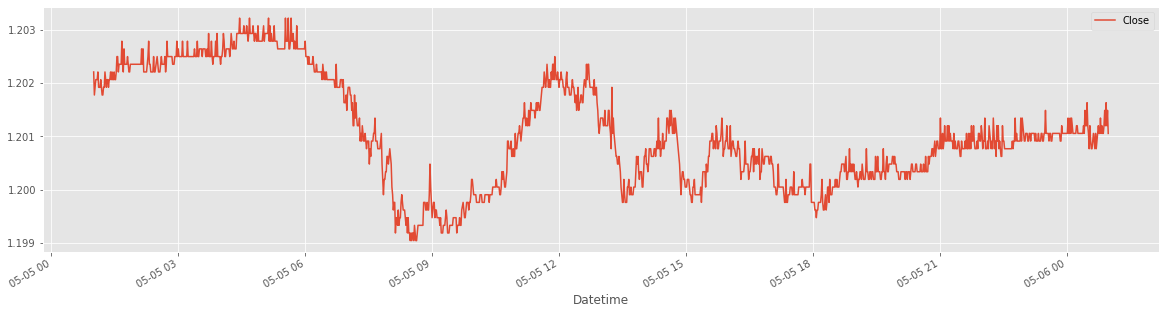

In [4]:
import pandas as pd

# Import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Read the data
data.index = pd.to_datetime(data.index, dayfirst=True)

# Visualise the data
plt.figure(figsize=(20,5))
data['Close'].plot(figsize=(20,5))
plt.legend()
plt.show()

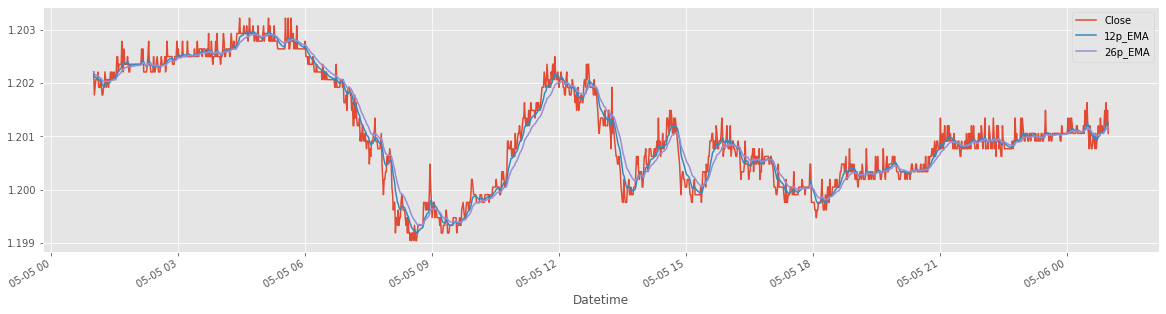

In [5]:
# Calculate exponential moving average
data['12p_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
data['26p_EMA'] = data.Close.ewm(span=26, adjust=False).mean()

data[['Close','12p_EMA','26p_EMA']].plot(figsize=(20,5))
plt.show()



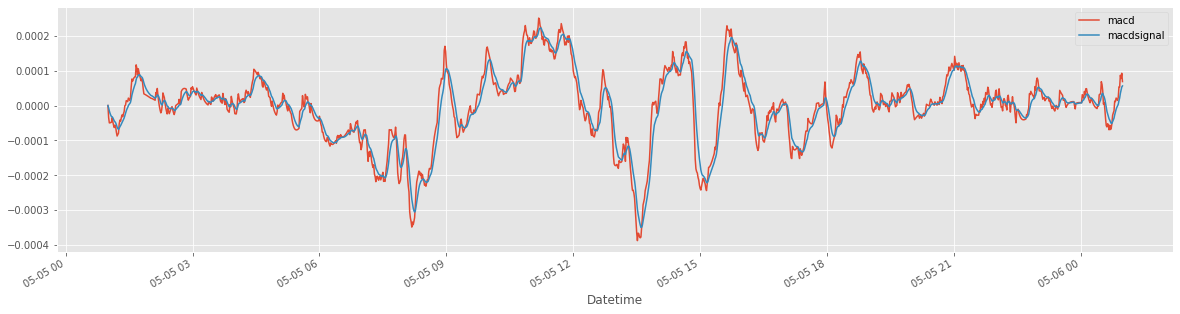

In [6]:
# Calculate MACD
data['macd'] = data['12p_EMA']- data['26p_EMA'] 

# Calculate Signal
data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()

data[['macd','macdsignal']].plot(figsize=(20,5))
plt.show()

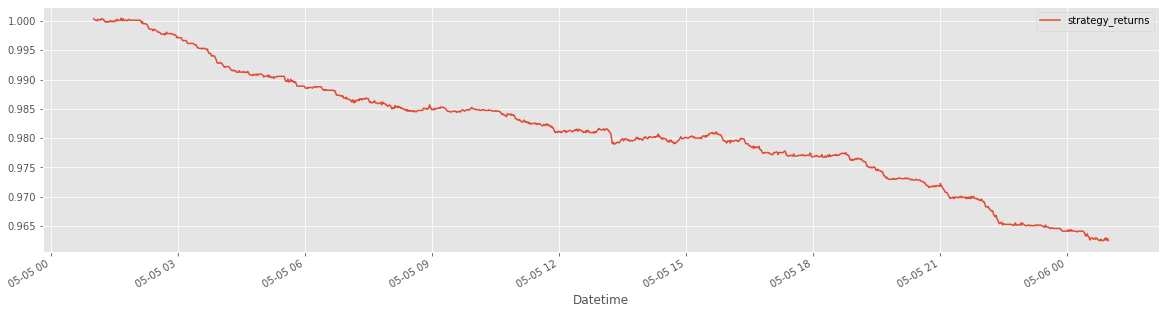

In [7]:
# Import numpy
import numpy as np

# Define Signal
data['trading_signal'] = np.where(data['macd'] > data['macdsignal'], 1, -1)

# Calculate Returns
data['returns'] = data.Close.pct_change()

# Calculate Strategy Returns
data['strategy_returns'] = data.returns * data.trading_signal.shift(1)

# Calculate Cumulative Returns
cumulative_strategy_returns = (data.strategy_returns + 1).cumprod()

# Plot Strategy Returns
cumulative_strategy_returns.plot(figsize=(20,5))
plt.legend()
plt.show()

In [12]:

# Compound Annual Growth Rate
# Total number of trading days
days = len(cumulative_strategy_returns) 

# Calculate compounded annual growth rate
annual_returns = (cumulative_strategy_returns.iloc[-1]**(252/days) - 1)*100  

print('The CAGR is %.2f%%' % annual_returns)

# Calculate the annualised volatility
annual_volatility = data.strategy_returns.std() * np.sqrt(252) * 100 
print('The annualised volatility is %.2f%%' % annual_volatility)

# Assume the annual risk-free rate is 6%
risk_free_rate = 0.06
daily_risk_free_return = risk_free_rate/252

# Calculate the excess returns by subtracting the daily returns by daily risk-free return
excess_daily_returns = data.strategy_returns - daily_risk_free_return

# Calculate the sharpe ratio using the given formula
sharpe_ratio = (excess_daily_returns.mean() /
                excess_daily_returns.std()) * np.sqrt(252)

print('The Sharpe ratio is %.2f' % sharpe_ratio)


The CAGR is -0.67%
The annualised volatility is 0.25%
The Sharpe ratio is -26.87


/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)
/usr/local/lib/python3.7/dist-packages/mplfinance/plotting.py:535: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


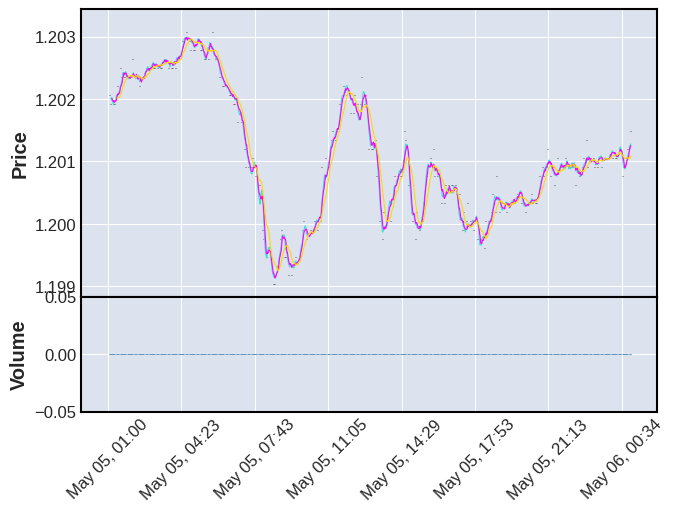

In [ ]:
import mplfinance as mpf

mpf.plot(data,type='candle',mav=(9,12,26),volume=True)